In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import atoti as tt
import calendar

Welcome to atoti 0.6.5!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, set the ATOTI_DISABLE_TELEMETRY environment variable to True.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [2]:
priceList = pd.read_excel("PriceList/202204價格表.xlsx", None)

In [3]:
priceTBR = priceList["TBR"]

In [4]:
priceLSR = priceList["LSR"]

In [5]:
priceTBR = priceTBR[['規格', '花紋', 'ISO', '層數', '進 / 國', '國別', 'RFT', '料號', '含稅價']]

In [6]:
priceLSR = priceLSR[['規格', '花紋', 'ISO', '層數', '進 / 國', '國別', 'RFT', '料號', '含稅價']]

In [7]:
priceList = pd.concat([priceTBR, priceLSR], axis=0).reset_index(drop=True)

In [8]:
priceList["含稅價"] = round(priceList["含稅價"],0)

In [9]:
priceList["含稅價"] = priceList["含稅價"].astype(int)

In [10]:
priceList.columns = priceList.columns.str.replace("/", "")

In [11]:
priceList["未稅價"] = round(priceList["含稅價"] / 1.05, 0)

In [12]:
priceList["未稅價"] = priceList["未稅價"].astype(int)

In [13]:
priceList

,規格,花紋,ISO,層數,進 國,國別,RFT,料號,含稅價,未稅價
0,215/70R17.5,R225,123J,,進,JP,T,TBR06242,9800,9333
1,215/70R17.5,R184,135J,,進,JP,T,TBR02847,9800,9333
2,225/80R17.5,R225,123L,,進,JP,T,TBR06435,8600,8190
3,225/90R17.5,R225,127L,,進,JP,T,TBR06254,8500,8095
4,225/90R17.5,M810,127L,,進,JP,T,TBR06042,8900,8476
...,...,...,...,...,...,...,...,...,...,...
118,235/75R17.5,R156,132M,,進,TH,T,LSR0L018,6900,6571
119,235/75R175,R156,132M,,進,TH,T,LSR0L041,6900,6571
120,9.5R17.5,R294,129M,,進,JP,T,LSR03459,7900,7524
121,9.5R17.5,R294,129M,,進,TH,T,LSR0L035,7900,7524


## 處理OB22

In [14]:
new_ob = pd.read_csv("./ReferenceTable/22OB_revised.csv")

In [15]:
sales_2021 = pd.read_csv("./ReferenceTable/2021實績.csv")

In [16]:
# new_ob.columns = ['輪胎類型', 'Channel', 'Group', 'Month', 'Qty']
sales_2021.columns = ['Tire Types', '通路', '細分類', 'Month', '總數']

In [17]:
sales_2021["總數"] = sales_2021["總數"].astype(int)

## 原始OB數據

In [18]:
df = pd.read_csv("./ReferenceTable/OB22_volume.csv")

In [19]:
df["Customer Group"].unique()

array(['BSSC', 'AG', 'FLT-REP', 'FLT-OE'], dtype=object)

In [20]:
df["Channel"].unique()

array(['REP', 'OE '], dtype=object)

## 22OB從Billy資料整理

In [21]:
ob22 = pd.read_excel("./ReferenceTable/ob22_20220412.xlsx")

In [22]:
ob22 = ob22.groupby(["Tire Types", "大分類", "小通路", "年份"]).sum().stack().reset_index(name="Qty")

In [23]:
ob22.columns = ['Tire Types', '大分類', '小通路', '年份', 'Month', 'Qty']

In [24]:
ob22 = ob22.astype({"年份": str})

In [25]:
# df.shape

In [26]:
# df = df[df["Qty"] != 0]

In [27]:
# df["Customer Group"].unique()

In [28]:
# df.columns = ["Tire type", "PCODE", "Channel", "Customer Group", "Description", "Pattern", "Qty", "Year", "Month"]

In [29]:
# df = df.astype({"Year": str})

In [30]:
# df["Channel"].unique()

In [31]:
# df["Customer Group"].unique()

## 加入SAP BSSC和AG銷售數據
### 均為含稅單價

In [32]:
bssc_sales = pd.read_csv("./SalesData/BSSC_raw_data.csv")

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (16,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [33]:
ag_sales = pd.read_csv("./SalesData/ag_raw_data.csv")

In [34]:
pcode_table = pd.read_csv("./ReferenceTable/pcode_dimension.csv")

In [35]:
category_table = pd.read_csv("./ReferenceTable/category_types.csv")

In [36]:
category_table["區域"] = category_table["區域"].str.strip()
category_table["營業所"] = category_table["營業所"].str.strip()

In [37]:
category_table = category_table.drop_duplicates(subset=["客戶代號"])

In [38]:
ag_sales.columns = ag_sales.columns.str.strip()

In [39]:
bssc_sales.columns = bssc_sales.columns.str.strip()

In [40]:
ag_sales = ag_sales[(ag_sales["S_配銷通路"].isin(["AG", "FT"])) & (ag_sales["S_中計商品代號1"].isin(["LR2", "TR2", "TR3", "TR5"]))]

In [41]:
ag_sales = ag_sales[["D_實際發貨日期", "S_訂單單號", "S_項次", "S_買方(客戶號碼)", "S_物料編號", "S_物料說明", "S_國別", "S_數量", "S_項目淨值"]]

In [42]:
bssc_sales = bssc_sales[bssc_sales["中計"].str.contains("LSR2|TBR")]

In [43]:
bssc_sales = bssc_sales[["實際出貨日", "訂單單號", "訂單項次", "買方", "物料", "物料說明", "國別", "銷售數量", "銷貨單價"]]

In [44]:
ag_sales["S_訂單單號"] = ag_sales["S_訂單單號"].astype(int).astype(str)

In [45]:
ag_sales.columns = bssc_sales.columns

In [46]:
bssc_sales["銷貨單價"] = bssc_sales["銷貨單價"].str.replace(",", "")
ag_sales["銷貨單價"] = ag_sales["銷貨單價"].str.replace(",", "")

AttributeError: Can only use .str accessor with string values!

In [47]:
type_keys = ['實際出貨日', '訂單單號', '訂單項次', '買方', '物料', '物料說明', '國別', '銷售數量', '銷貨單價']
type_values = [str, str, str, str, str, str, str, int, int]
type_dict = dict(zip(type_keys, type_values))

In [48]:
bssc_sales = bssc_sales.astype(type_dict)
ag_sales = ag_sales.astype(type_dict)

In [49]:
combined_sales = pd.concat([bssc_sales, ag_sales])

In [50]:
combined_sales["實際出貨日"] = pd.to_datetime(combined_sales["實際出貨日"], yearfirst=True)

In [51]:
# combined_sales["實際出貨日"].dt.quarter

In [52]:
combined_sales["年份"] = combined_sales["實際出貨日"].dt.year.astype(str)
combined_sales["日期"] = combined_sales["實際出貨日"].dt.date
combined_sales["月份"] = combined_sales["實際出貨日"].dt.month_name()

In [53]:
keys = ["買方", "訂單單號", "訂單項次", "實際出貨日"]

In [54]:
combined_sales["Tire Types"] = combined_sales["物料"].map(lambda x: "TBR" if x[:3] == "TBR" else "LSR2")

In [55]:
# client_name_dict = dict(zip(category_table["客戶代號"], category_table["客戶"]))
# channel_dict = dict(zip(category_table["客戶代號"], category_table["大分類"]))
# category_dict = dict(zip(category_table["客戶代號"], category_table["大通路"]))
# group_dict = dict(zip(category_table["客戶代號"], category_table["小通路"]))
# area_dict = dict(zip(category_table["客戶代號"], category_table["區域"]))

In [56]:
# combined_sales["客戶名稱"] = combined_sales["買方"].map(client_name_dict)
# combined_sales["大分類"] = combined_sales["買方"].map(channel_dict)
# combined_sales["大通路"] = combined_sales["買方"].map(category_dict)
# combined_sales["小通路"] = combined_sales["買方"].map(group_dict)
# combined_sales["區域"] = combined_sales["買方"].map(area_dict)

In [57]:
combined_sales = combined_sales.drop_duplicates()

## 建立Atoti Session

In [245]:
test = pd.read_clipboard()

In [246]:
test = test.astype({"Year": str})

In [247]:
# n_session = tt.create_session(config={"user_content_storage": "./atoti_pages", "port": 12345})
n_session = tt.create_session()

/opt/anaconda3/lib/python3.8/site-packages/atoti/_create_session.py:16: FutureWarning: Creating sessions with `create_session()` is deprecated, use `Session()` directly instead.
  deprecated(
Deleting existing "Unnamed" session to create the new one.


- 建立銷售實績Table(From SAP)
- 建立PCODE對照表
- 建立新價格表
- 建立22OB表格
- 建立2021實績表格

In [248]:
root = n_session.read_pandas(test, keys=["Tire Types", "類型", "Year", "Month"], table_name="Root", types={"Year": tt.type.STRING})

In [249]:
combined_sales["類型"] = "實績"

In [250]:
bssc = n_session.read_pandas(combined_sales, keys=["訂單單號", "訂單項次"], table_name="TOTAL SALES", types={"年份": tt.type.STRING})

In [251]:
pcode = n_session.read_pandas(pcode_table, keys=["PrCode"], table_name="PCODE")

In [252]:
category = n_session.read_pandas(category_table, keys=["客戶代號"], table_name="CUSTOMER TABLE")

In [ ]:
ob = n_session.read_pandas(new_ob, keys=["Tire Types", "Channel", "Group", "Month"], table_name="22OB")

In [ ]:
sales_21 = n_session.read_pandas(sales_2021, keys=["Tire Types", "通路", "細分類", "Month"], table_name="22 Sales")

In [253]:
new_price = n_session.read_pandas(priceList, keys=["料號"], table_name="New Price")

In [254]:
ob22["類型"] = "預算"

In [255]:
ob22.columns = ["輪胎類型", "大分類", "小通路", "Year", "Month", "Qty", "類型"]

In [256]:
ob = n_session.read_pandas(ob22, keys=['輪胎類型', '大分類', '小通路', 'Year', 'Month', "類型"], table_name="22OB")

In [257]:
root.join(ob, mapping={"Tire Types": "輪胎類型", "類型": "類型", "Year": "Year", "Month": "Month"})
root.join(bssc, mapping={"Tire Types": "Tire Types", "類型": "類型", "Year": "年份", "Month": "月份"})
bssc.join(category, mapping={"買方": "客戶代號"})
bssc.join(new_price, mapping={"物料": "料號"})
new_price.join(pcode, mapping={"料號": "PrCode"})
# category.join(ob, mapping={"大分類": "大分類", "小通路": "小通路"})

## 建立Cube魔方
1. 建立Cube
2. 建立Hierarchy, Levels, Measures

In [258]:
# new_cube = n_session.create_cube(bssc, "BSSC SALES ANALYSIS")
new_cube = n_session.create_cube(root, "BSSC SALES ANALYSIS")

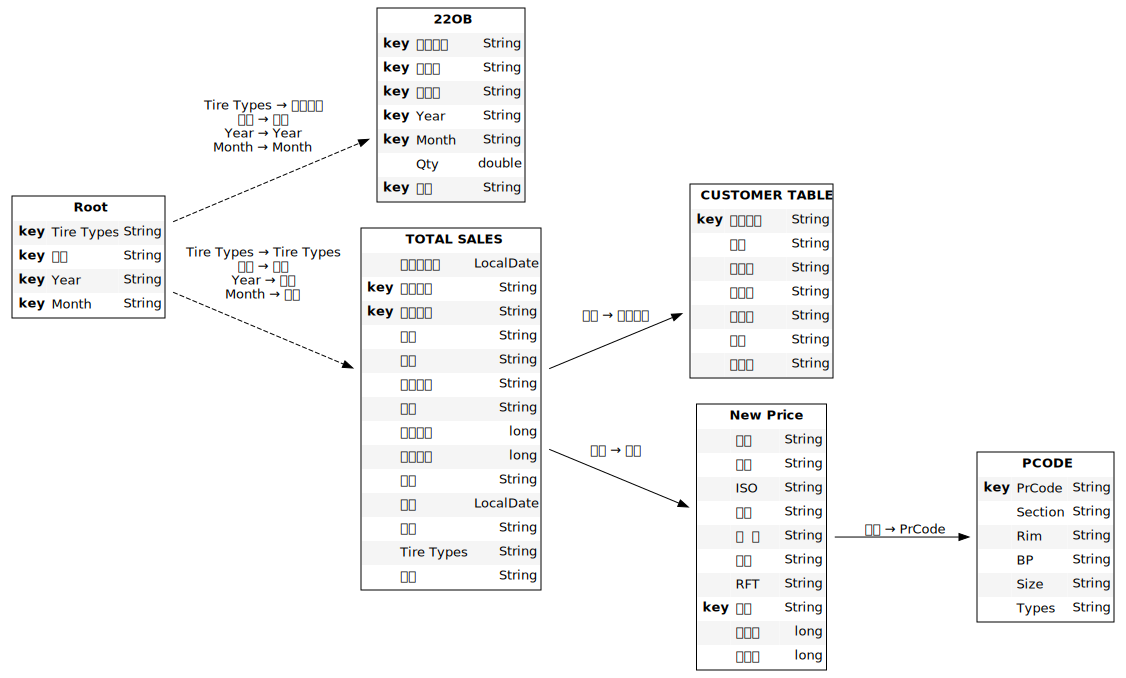

In [259]:
new_cube.schema

In [260]:
h, l, m = new_cube.hierarchies, new_cube.levels, new_cube.measures

In [261]:
m["預算數量"] = tt.agg.sum(ob["Qty"])

In [262]:
m["實績數量"] = tt.agg.sum(bssc["銷售數量"])

In [263]:
m["新價格"] = tt.value(new_price["未稅價"])

In [264]:
l["Month"].comparator = tt.comparator.first_members('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')

/opt/anaconda3/lib/python3.8/site-packages/atoti/level.py:66: FutureWarning: `Level.comparator` is deprecated, use `Level.order` instead.
  deprecated("`Level.comparator` is deprecated, use `Level.order` instead.")


In [266]:
m["實績/預算達成率"] = m["實績數量"] / m["預算數量"]
m["實績/預算達成率"].formatter = "DOUBLE[0%]"

In [239]:
m["未稅銷貨單價"] = m["銷貨單價.MEAN"] / 1.05

KeyError: 'No measure named 銷貨單價.MEAN'

In [151]:
m["漲幅"] = m["新價格"] / m["未稅銷貨單價"] - 1
m["漲幅"].formatter = "DOUBLE[0.0%]"

## 加入關聯Table

In [ ]:
bssc.join(category, mapping={"買方": "客戶代號"})

In [ ]:
bssc.join(ob, mapping={"Tire Types": "Tire Types", "年份": "年份", "月份": "Month"})

In [ ]:
m["22OB.SUM"] = tt.agg.sum(ob["Qty"])

In [ ]:
m["test value"] = tt.where(l["Big"] == "OE", m["22OB.SUM"], 0)

In [ ]:
new_cube.query(m["22OB.SUM"], levels=[l["Big"], l["Small"]])

In [ ]:
n_session.visualize()

In [ ]:
bssc.join(pcode, mapping={"物料": "PrCode"})
# bssc.join(category, mapping={"買方": "客戶代號"})

In [ ]:
bssc.join(ob, mapping={"Tire Types": "Tire Types", "大分類": "Channel", "小通路": "Group", "月份": "Month"})
# bssc.join(sales_21, mapping={"Tire Types": "Tire Types", "大分類": "通路", "小通路": "細分類", "月份": "Month"})
bssc.join(new_price, mapping={"物料": "料號"})

In [ ]:
# category.join(ob, mapping={"大分類": "Channel", "小通路": "Group"})

## 建立Hierarchy

In [ ]:
h["通路別"] = [bssc["Tire Types"], bssc["大分類"], bssc["小通路"]]

In [ ]:
h["通路別"] = [pcode["Types"], category["大通路"], category["區域"], category["大分類"], category["小通路"], category["客戶"]]
h["時間"] = [l["年份"], l["月份"], l["日期"]]
h["實績通路別"] = [pcode["Types"], category["大分類"], category["小通路"]]

In [ ]:
months = [calendar.month_name[i] for i in range(1, 13)]
l["TOTAL SALES", "月份", "月份"].comparator = tt.comparator.first_members('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December')

In [ ]:
m["2021 value"] = tt.value(sales_21["總數"])

In [ ]:
m["2021 Volume.SUM"] = tt.agg.sum(sales_21["總數"])

In [ ]:
m["22OB Volume.SUM"] = tt.agg.sum(ob["Qty"])

In [ ]:
del h["大分類"]
del h["大通路"]
del h["小通路"]

In [ ]:
h["時間"] = [l["年份"], l["月份"], l["日期"]]

In [ ]:
del h["實際出貨日"]
del h["年份"]
del h["日期"]
del h["月份"]

In [265]:
n_session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### 如果需要其他的hierarchy也一起在degree裡面去分析的話，可以以dictionary的形式繼續增加

In [ ]:
# m["Parent category volume"] = tt.parent_value(m["銷售數量.SUM"], degrees={h[("CUSTOMER TABLE", "通路別")]:1, h[("CUSTOMER TABLE", "客戶")]:1}, apply_filters=True, total_value=m["銷售數量.SUM"])
m["Parent category volume"] = tt.parent_value(m["銷售數量.SUM"], degrees={h["通路別"]:1}, apply_filters=True, total_value=m["銷售數量.SUM"])


In [ ]:
m["Percent of parent volume"] = m["銷售數量.SUM"] /  m["Parent category volume"]
m["Percent of parent volume"].formatter = "DOUBLE[0.0%]"

## 加入OB22和新的價格表

In [ ]:
bssc.join(ob, mapping={"物料": "PCODE", "年份": "Year", "月份": "Month"})

In [ ]:
m["22OB volume"] = tt.agg.sum(ob["Qty"])

In [ ]:
m["Hit rate(Sales vs OB)"] = m["銷售數量.SUM"] / m["22OB volume"]
m["Hit rate(Sales vs OB)"].formatter = "DOUBLE[0%]"

In [ ]:
m["Old Unit Price"] = tt.agg.mean(bssc["銷貨單價"])
m["Old Unit Price"].formatter = "DOUBLE[0]"

## 比較新舊價格的發現（不穩定）

In [ ]:
m["New Unit Price"] = tt.value(new_price["含稅價"])

In [ ]:
m["Price Index"] = m["New Unit Price"] / m["Old Unit Price"] - 1
m["Price Index"].formatter = "DOUBLE[0%]"

## 建立銷貨單價measure

In [ ]:
m["Unit Price"] = tt.value(bssc["銷貨單價"])
m["Unit Price"].formatter = "INT[0]"